# 1. Fourier Spectral Grid

In [1]:
import numpy as np

from scipy.linalg import inv
from scipy.fft import fft, ifft

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
N = 16

row = np.arange(N)[:, None]
col = np.arange(N)[None, :]

def aliased_index(k, N):
    return k - N * (k >= (N + 1)//2)

def is_the_same(A, B):
    return np.max(np.abs(A - B)) < 1e-6

spectral_grid  = 2 * np.pi * row / N                       # Trefethen adds 2*pi /N to this grid. I like it this way instead.
dense_grid     = np.linspace(0, 2*np.pi, 1000)[:, None]

spectral_basis = np.exp(1j * aliased_index(col, N) * spectral_grid)
dense_basis    = np.exp(1j * aliased_index(col, N) * dense_grid)

if N % 2 == 0:                                          # Here we remove the imaginary part of the Nyquist mode.
    dense_basis[:, N//2] = dense_basis[:, N//2].real    # This is equivalent to Trefethen's trick in page 19.

## 1.1 Aliasing and the Nyquist frequency


Frequencies on the grid: [ 0  1  2  3  4  5  6  7 -8 -7 -6 -5 -4 -3 -2 -1].



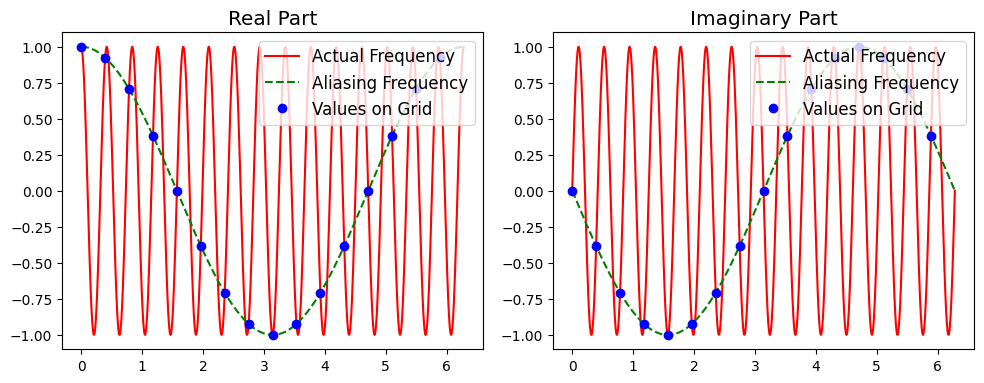

In [3]:
n = 15    # Try values at the Nyquist frequency N//2 and higher.

print(f'\nFrequencies on the grid: {aliased_index(np.arange(N), N)}.\n')

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].set_title('Real Part')
ax[0].plot(dense_grid, np.exp(1j * n * dense_grid).real, 'r-', label = 'Actual Frequency')
ax[0].plot(dense_grid, dense_basis[:, n].real, 'g--', label = 'Aliasing Frequency')
ax[0].plot(spectral_grid, spectral_basis[:, n].real, 'bo', label = 'Values on Grid')
ax[0].legend(loc = 'upper right')
ax[0].set_ylim(-1.1, 1.1)

ax[1].set_title('Imaginary Part')
ax[1].plot(dense_grid, np.exp(1j * n * dense_grid).imag, 'r-', label = 'Actual Frequency')
ax[1].plot(dense_grid, dense_basis[:, n].imag, 'g--', label = 'Aliasing Frequency')
ax[1].plot(spectral_grid, spectral_basis[:, n].imag, 'bo', label = 'Values on Grid')
ax[1].legend(loc = 'upper right')
ax[1].set_ylim(-1.1, 1.1)

plt.tight_layout()
################################################################################

## 1.2 Orthogonality and the Slow Fourier Transform :)

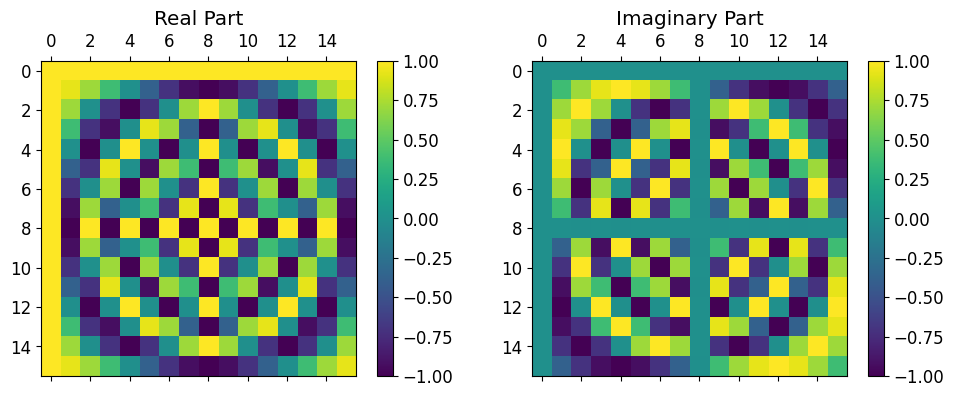

In [4]:
################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].set_title('Real Part')
pt0 = ax[0].matshow(spectral_basis.real)
plt.colorbar(pt0, ax = ax[0])

ax[1].set_title('Imaginary Part')
pt1 = ax[1].matshow(spectral_basis.imag)
plt.colorbar(pt1, ax = ax[1])

plt.tight_layout()
################################################################################

True


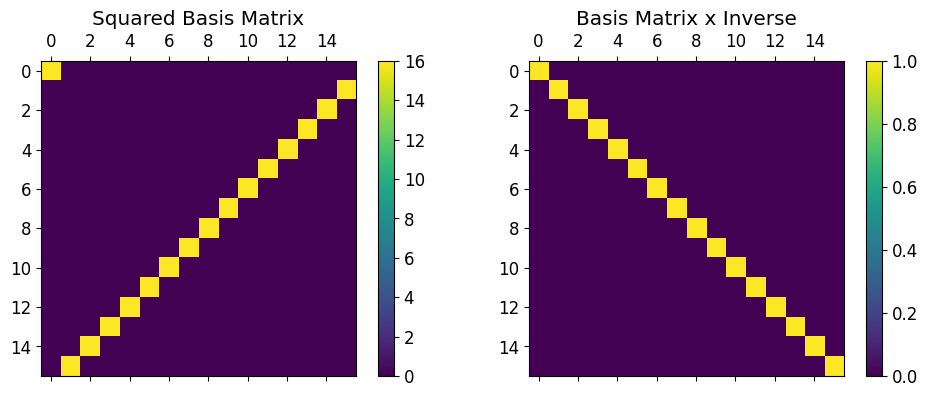

In [5]:
spectral_basis_inv = spectral_basis.conjugate() / N

print(is_the_same(spectral_basis_inv, inv(spectral_basis)))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].set_title('Squared Basis Matrix')
pt0 = ax[0].matshow(np.abs(spectral_basis @ spectral_basis))
plt.colorbar(pt0, ax = ax[0])

ax[1].set_title('Basis Matrix x Inverse')
pt1 = ax[1].matshow(np.abs(spectral_basis @ spectral_basis_inv))
plt.colorbar(pt1, ax = ax[1])

plt.tight_layout()
################################################################################

In [6]:
f = np.exp(np.sin(spectral_grid))

actual_FFT = fft(f.flatten())
matrix_FFT = N * (spectral_basis_inv @ f).flatten()
is_the_same(actual_FFT, matrix_FFT)

True

## 1.3 The cardinal functions

True


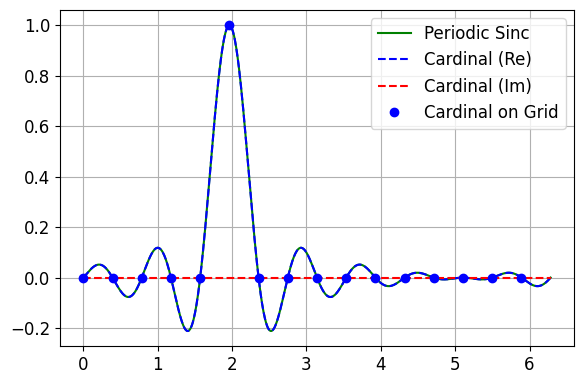

In [7]:
n = 5

def sinc(x, N):
    x0 = (x == 0)
    if N%2 == 0:
        return x0 + np.sin(N * x / 2) / (N * np.tan(x / 2) + x0)
    else:
        return x0 + np.sin(N * x / 2) / (N * np.sin(x / 2) + x0)

spectral_cardinals = np.eye(N)
dense_cardinals    = dense_basis @ spectral_basis_inv

print(is_the_same(sinc(dense_grid - spectral_grid[n], N), dense_cardinals[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid,    sinc(dense_grid - spectral_grid[n], N), color = 'green', label = 'Periodic Sinc')
ax.plot(dense_grid,    dense_cardinals[:, n].real, 'b--', label = 'Cardinal (Re)')
ax.plot(dense_grid,    dense_cardinals[:, n].imag, 'r--', label = 'Cardinal (Im)')
ax.plot(spectral_grid, spectral_cardinals[:, n], 'bo', label = 'Cardinal on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

True


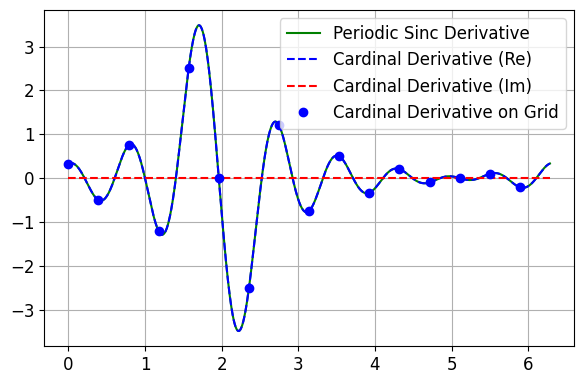

In [8]:
n = 5

def sinc_diff(x, N):
    x0 = (x == 0)
    if N % 2 == 0:
        return 0.5 * np.cos(N * x / 2) / (np.tan(x / 2) + x0) - np.sin(N * x / 2) / (2 * N * np.sin(x / 2)**2 + x0)
    else:
        return 0.5 * np.cos(N * x / 2) / (np.sin(x / 2) + x0) - np.sin(N * x / 2) / (2 * N * np.sin(x / 2) * np.tan(x / 2) + x0)

spectral_basis_diff   = 1j * aliased_index(col, N) * np.exp(1j * aliased_index(col, N) * spectral_grid)
dense_basis_diff      = 1j * aliased_index(col, N) * np.exp(1j * aliased_index(col, N) * dense_grid)

if N % 2 == 0:                                                          #Here we remove the imaginary part of the Nyquist mode.
    spectral_basis_diff[:, N//2] = spectral_basis_diff[:, N//2].real    #This is equivalent to Trefethen's trick in page 19.
    dense_basis_diff[:, N//2]    = dense_basis_diff[:, N//2].real    

diff_matrix          = spectral_basis_diff @ spectral_basis_inv
dense_cardinals_diff = dense_basis_diff @ spectral_basis_inv

print(is_the_same(sinc_diff(dense_grid - spectral_grid[n], N), dense_cardinals_diff[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid,    sinc_diff(dense_grid - spectral_grid[n], N), color = 'green', label = 'Periodic Sinc Derivative')
ax.plot(dense_grid,    dense_cardinals_diff[:, n].real, 'b--', label = 'Cardinal Derivative (Re)')
ax.plot(dense_grid,    dense_cardinals_diff[:, n].imag, 'r--', label = 'Cardinal Derivative (Im)')
ax.plot(spectral_grid, diff_matrix[:, n].real, 'bo',   label = 'Cardinal Derivative on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

## 1.4 Fourier Differentiation Matrices and Interpolation

In [9]:
def FourierD(N):
    row = np.arange(N)[:, None]
    col = np.arange(N)[None, :]
    I  = np.eye(N)
    Ic = np.ones((N, N)) - I
    
    x = 2 * np.pi * row / N
    h = (x[1] - x[0])[0]
    
    if N % 2 == 0:
        center = - (N**2 + 2) / 12
        D1 = Ic * 0.5 * (-1)**(row + col) / np.tan(0.5 * ((row - col) * h) + I)
        D2 = Ic * 0.5 * (-1)**(row + col + 1) / np.sin(0.5 * ((row - col) * h) + I)**2 + center * I
    else:
        center = (1 - N**2) / 12
        D1 = Ic * 0.5 * (-1)**(row + col) / np.sin(0.5 * ((row - col) * h) + I)
        D2 = Ic * 0.5 * (-1)**(row + col + 1) / (np.sin(0.5 * ((row - col) * h)) * np.tan(0.5 * ((row - col) * h)) + I) + center * I
    return x, D1, D2

x, D1, D2 = FourierD(N)
is_the_same(D1, diff_matrix)

True

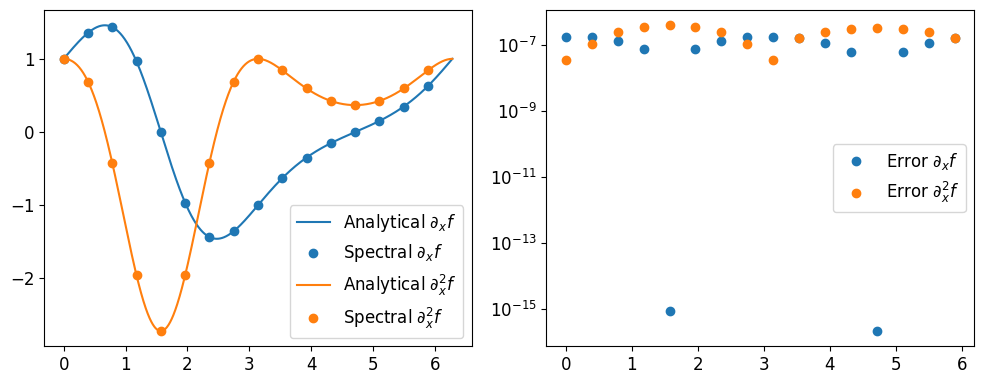

In [10]:
f   = np.exp(np.sin(x))
df  = np.cos(x) * f
ddf = (np.cos(x)**2 - np.sin(x)) * f

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ df,  label = 'Analytical $\partial_x f$',   color = colors[0])
ax[0].plot(x, D1 @ f, 'o', label = 'Spectral $\partial_x f$', color = colors[0])
ax[0].plot(dense_grid, dense_cardinals.real @ ddf, label = 'Analytical $\partial^2_x f$', color = colors[1])
ax[0].plot(x, D2 @ f, 'o', label = 'Spectral $\partial^2_x f$', color = colors[1])
ax[0].legend(loc = 'lower right')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(D1 @ f - df),  'o', label = 'Error $\partial_x f$', color = colors[0])
ax[1].plot(x, np.abs(D2 @ f - ddf), 'o', label = 'Error $\partial^2_x f$', color = colors[1])
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 1.5 FFT Differentiation


The frequencies for the first derivative are:  [ 0  1  2  3  4  5  6  7  0 -7 -6 -5 -4 -3 -2 -1].

The frequencies for the second derivative are: [ 0  1  2  3  4  5  6  7 -8 -7 -6 -5 -4 -3 -2 -1].


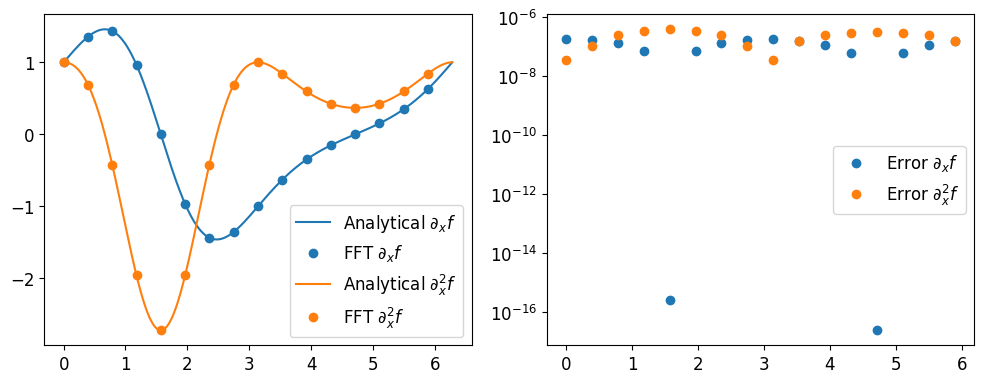

In [11]:
f   = np.exp(np.sin(x))
df  = np.cos(x) * f
ddf = (np.cos(x)**2 - np.sin(x)) * f

freqs1 = aliased_index(np.arange(N), N) 
freqs2 = aliased_index(np.arange(N), N)

if N % 2 == 0:         #Here we kill the derivative of the Nyquist mode.
    freqs1[N//2] = 0   #This is equivalent to Trefethen's trick in page 23.

print(f'\nThe frequencies for the first derivative are:  {freqs1}.')
print(f'\nThe frequencies for the second derivative are: {freqs2}.')

FFT_df  = ifft(1j * freqs1 * fft(f.flatten())).real
FFT_ddf = ifft(- freqs2**2 * fft(f.flatten())).real

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ df, label = 'Analytical $\partial_x f$',    color = colors[0])
ax[0].plot(x, FFT_df, 'o', label = 'FFT $\partial_x f$', color = colors[0])
ax[0].plot(dense_grid, dense_cardinals.real @ ddf, label = 'Analytical $\partial^2_x f$', color = colors[1])
ax[0].plot(x, FFT_ddf, 'o', label = 'FFT $\partial^2_x f$', color = colors[1])
ax[0].legend(loc = 'lower right')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(FFT_df - df.flatten()),   'o', label = 'Error $\partial_x f$', color = colors[0])
ax[1].plot(x, np.abs(FFT_ddf - ddf.flatten()), 'o', label = 'Error $\partial^2_x f$', color = colors[1])
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 1.6 Integration

In [12]:
np.abs(np.mean(spectral_basis, axis = 0))

array([1.00000000e+00, 3.53815554e-17, 4.90653893e-17, 3.97459940e-16,
       3.85786410e-16, 3.18074688e-16, 3.68807270e-16, 2.18464989e-16,
       2.83276945e-16, 2.18464989e-16, 3.68807270e-16, 3.18074688e-16,
       3.85786410e-16, 3.97459940e-16, 4.90653893e-17, 3.53815554e-17])

In [13]:
CorrectIntegral       = 7.9549265210128452728
TrapezoidRuleIntegral = 2 * np.pi * np.mean(f)

is_the_same(CorrectIntegral, TrapezoidRuleIntegral)

True